# Decision Trees for regression tasks

In [1]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate,\
                                    cross_val_score, train_test_split, ShuffleSplit, validation_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn import tree


In [2]:
np.random.seed(306)

In [3]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

## Load the dataset

In [4]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

#train - test split
com_train_features, test_features, com_train_labels,  test_labels = train_test_split(features, labels, random_state=42)

# train ---> train + dev split
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

## Model Set up

In [5]:
from numpy import std


dt_reg_pipeline = Pipeline([("scaling", StandardScaler()),
                            ("dt_reg", DecisionTreeRegressor(max_depth=3, random_state=42))])

dt_reg_cv_results = cross_validate(dt_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv = cv,
                                    scoring = "neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

dt_reg_train_error = -1 * dt_reg_cv_results['train_score']
dt_reg_test_error = -1 * dt_reg_cv_results['test_score']

print(f"Mean absolute error on the training set: \n"
        f"{dt_reg_train_error.mean():.3f} +/- {dt_reg_train_error.std():.3f}")
print(f"Mean absolute error on the testing set: \n"
        f"{dt_reg_test_error.mean():.3f} +/- {dt_reg_test_error.std():.3f}")

Mean absolute error on the training set: 
0.590 +/- 0.005
Mean absolute error on the testing set: 
0.593 +/- 0.007


## Visualising the tree

### As a tree diagram

In [6]:
dt_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])

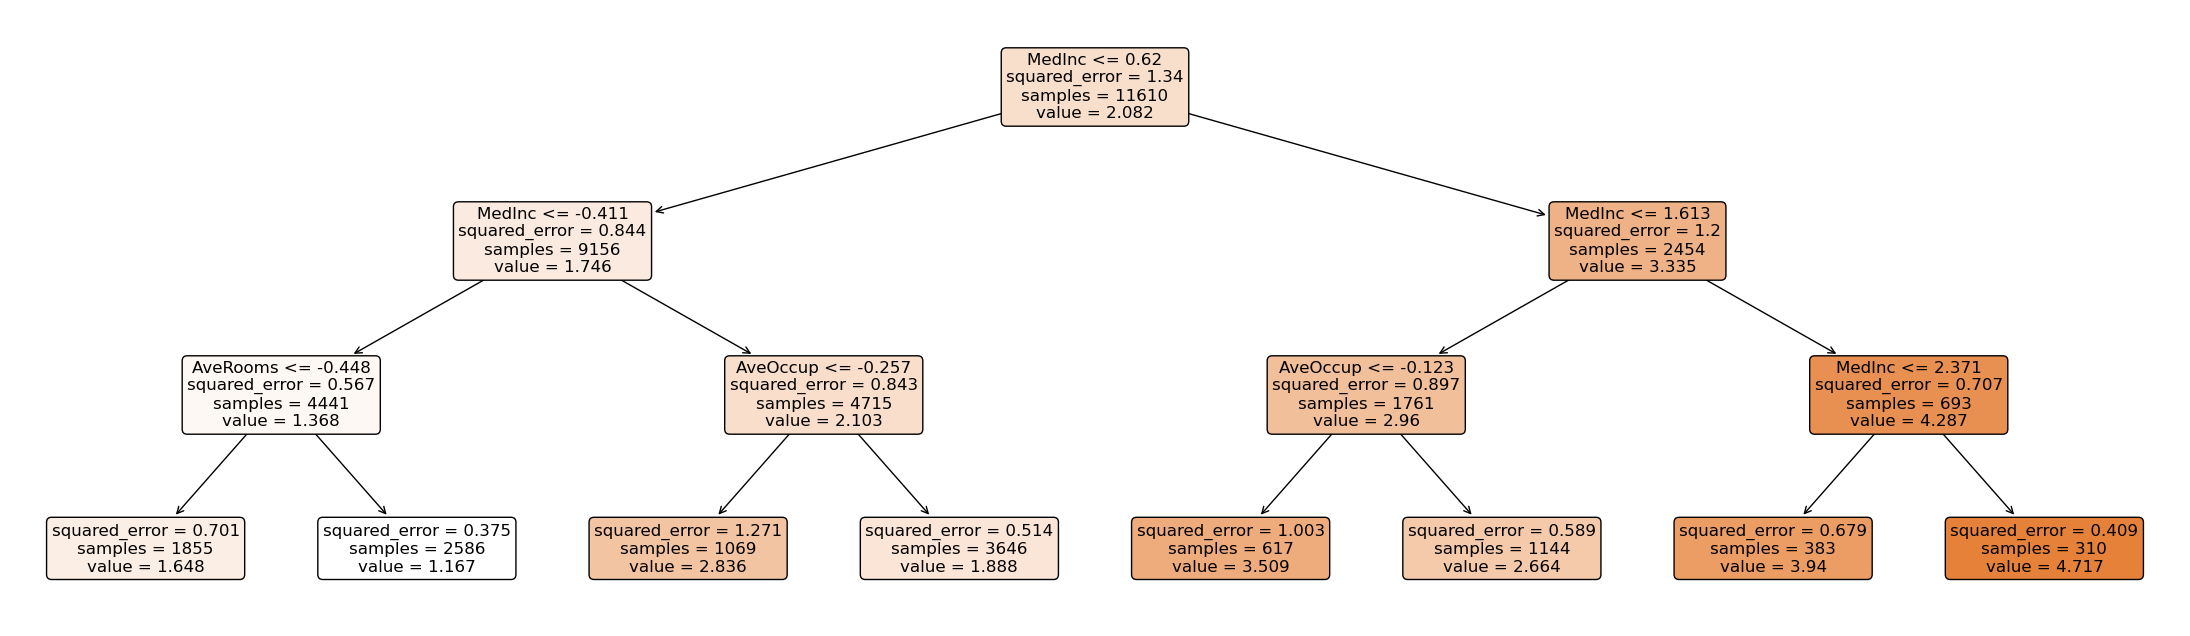

In [7]:
plt.figure(figsize=(28,8), facecolor='w')

a = tree.plot_tree(dt_reg_pipeline[-1],
                    feature_names = features.columns,
                    rounded = True,
                    filled = True,
                    fontsize = 12)

plt.show()

### As a text based diagram

In [26]:
tree_rules = export_text(dt_reg_pipeline[-1])
print(tree_rules)

|--- feature_0 <= 0.62
|   |--- feature_0 <= -0.41
|   |   |--- feature_2 <= -0.45
|   |   |   |--- value: [1.65]
|   |   |--- feature_2 >  -0.45
|   |   |   |--- value: [1.17]
|   |--- feature_0 >  -0.41
|   |   |--- feature_5 <= -0.26
|   |   |   |--- value: [2.84]
|   |   |--- feature_5 >  -0.26
|   |   |   |--- value: [1.89]
|--- feature_0 >  0.62
|   |--- feature_0 <= 1.61
|   |   |--- feature_5 <= -0.12
|   |   |   |--- value: [3.51]
|   |   |--- feature_5 >  -0.12
|   |   |   |--- value: [2.66]
|   |--- feature_0 >  1.61
|   |   |--- feature_0 <= 2.37
|   |   |   |--- value: [3.94]
|   |   |--- feature_0 >  2.37
|   |   |   |--- value: [4.72]



## Evaluation

In [27]:
test_labels_pred = dt_reg_pipeline.predict(test_features)

mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)

print("MAE: ", mae)
print("MSE: ", mse)

MAE:  0.6005762942842664
MSE:  0.6417557936098145


## HP tuning

In [30]:
param_grid = {'dt_reg__max_depth': range(1, 20),
            'dt_reg__min_samples_split': range(2, 8)}
dt_grid_search = GridSearchCV(dt_reg_pipeline,
                                param_grid=param_grid,
                                n_jobs=2,
                                cv= cv,
                                scoring='neg_mean_absolute_error',
                                return_train_score=True)
dt_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('dt_reg',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=2,
             param_grid={'dt_reg__max_depth': range(1, 20),
                         'dt_reg__min_samples_split': range(2, 8)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [31]:
dt_grid_search.best_params_

{'dt_reg__max_depth': 11, 'dt_reg__min_samples_split': 5}

In [32]:
dt_reg_pipeline.set_params(dt_reg__max_depth=11, dt_reg__min_samples_split=5).fit(com_train_features, com_train_labels)

Pipeline(steps=[('scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=11, min_samples_split=5,
                                       random_state=42))])

In [34]:
test_labels_pred = dt_reg_pipeline.predict(test_features)

mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)
r2 = r2_score(test_labels, test_labels_pred)

print("MAE: ", mae)
print("MSE: ", mse)
print("R2 score: ", r2)

MAE:  0.4248952183820017
MSE:  0.4154957726373763
R2 score:  0.6859960039130073
